# Специализированные программные библиотеки для анализа данных.

## Укажите ФИО и группу
# Бортников Павел Павлович 20215

### Импортируем необходимые модули 

In [2]:
import numpy as np
import pandas as pd
import datetime

### Ваш набор данных - сводка по эпидемиологической обстановке в России. В этом домашнем задании 6 пунктов, постарайтесь выполнить их все. Всего за эту домашку можно получить 8 баллов.

### 1. Препроцессинг данных (2 балла)

Подготовьте данные для анализа. Загрузите файлы COVID_RU_Ya_stat_2022.csv и COVID_RU_Ya_descr.csv, объедините эти две таблицы в одну. Преобразуйте тип данных в колонке "Дата" к типу "datetime64" и введите двойной индекс на основе колонок "Регион" и "Дата". Добавьте в вашу таблицу новые колонки. Отсортируйте таблицу по индексам. Выведите 5 первых строчек получившейся таблицы.

In [3]:
## прочитайте данные из файла 'COVID_RU_Ya_descr.csv'
ncov_ru_de = pd.read_csv('./hwfiles/COVID_RU_Ya_descr.csv')
## прочитайте данные из файла 'COVID_RU_Ya_stat_2022.csv'
ncov_ru_stat = pd.read_csv('./hwfiles/COVID_RU_Ya_stat_2022.csv')


# Как правило хорошего тона (не уверен, что распространяется на датасаенсссс), все же переименую колонки


ncov_ru_de.rename({
    'Регион': 'region',
    'Регион название': 'regionName',
    'Регион население': 'regionPopulation',
    'ФО': 'FO'
}, axis='columns', inplace=True, errors='raise')
ncov_ru_de.drop(['Unnamed: 0'], axis=1, inplace=True, errors='raise')

ncov_ru_stat.rename({
    'Регион': 'region',
    'Дата': 'date',
    'Заражений': 'infected',
    'Заражений за день': 'infected_pd',  #per day
    'Выздоровлений': 'recovered',
    'Выздоровлений за день': 'recovered_pd',
    'Смертей': 'deaths',
    'Смертей за день': 'deaths_pd',
    'Летальность, %': 'lethality',
}, axis='columns', inplace=True, errors='raise')
ncov_ru_stat.drop(['Unnamed: 0'], axis=1, inplace=True, errors='raise')
ncov_ru_stat

,date,region,infected,recovered,deaths,deaths_pd,infected_pd,recovered_pd,lethality
0,20.10.2020,Пермский край,11862,7993,355,5,128,81,2.99
1,29.12.2021,Татарстан,42537,36175,1425,5,80,100,3.35
2,23.01.2021,Марий Эл,10309,8980,147,0,46,56,1.43
3,14.05.2021,Красноярский край,71858,66180,3628,8,102,90,5.05
4,12.04.2022,Крым,180027,172186,5158,6,141,157,2.87
...,...,...,...,...,...,...,...,...,...
79453,10.01.2021,Кемеровская обл.,27032,24221,488,1,116,105,1.81
79454,03.07.2021,Смоленская обл.,35314,31844,1133,8,257,93,3.21
79455,16.12.2020,Ульяновская обл.,32062,29113,415,0,289,324,1.29
79456,26.11.2020,Свердловская обл.,44775,36975,988,8,391,395,2.21


In [4]:
## объедените таблицы ncov_ru_de и ncov_ru_stat -- необходимо использовать какой-то ключ для объединения 
## и что это за поле могло бы быть ключом?

ncov_ru_j = pd.merge(ncov_ru_stat, ncov_ru_de, how='left', on='region')

In [5]:
## так можно посмотреть колонки:
#  ncov_ru_de.columns
#  ncov_ru_stat.columns
## так можно посмотреть индексы:
#  ncov_ru_de.index
#  ncov_ru_stat.index

## преобразуйте тип данных в колонке "Дата" к типу "datetime64" -- примеры в нашем занятии
ncov_ru_j.date = pd.to_datetime(ncov_ru_j.date, dayfirst=True)
## задайте в вашей таблице индексацию по полям "Регион" и "Дата"
ncov_ru_j.set_index(['region', 'date'], inplace=True)

In [6]:
perNPopulation = 100000


def add_cols_per_n_population(df, cols, per_n, population_col_name):
    for col in cols:
        df[col + f"_{round(per_n / 1000)}k"] = df[col] / df[population_col_name] * per_n
    return df


## Создайте в вашей таблице колонки:
# "Активных" - число активных случаев = 'Заражений' - 'Выздоровлений' - 'Смертей'
ncov_ru_j['active'] = ncov_ru_j.infected - ncov_ru_j.recovered - ncov_ru_j.deaths

# "Активных на 100К населения"
# "Заражений на 100К населения"
# "Смертей на 100К населения"
# "Заражений за день на 100К населения"
# "Смертей за день на 100К населения"
ncov_ru_j = add_cols_per_n_population(
    ncov_ru_j,
    ['active', 'infected', 'deaths', 'infected_pd', 'deaths_pd'],
    perNPopulation,
    'regionPopulation'
)
ncov_ru_j.to_csv('./hwfiles/ncov_ru_j.csv')

### 2. Подсчёт численности населения (1 балл)

Посчитайте численность населения в федеральных округах и в РФ.

In [17]:
fo_population = ncov_ru_de.groupby('FO').regionPopulation.sum()
ru_population = fo_population.sum()
fo_population

FO
Дальневосточный федеральный округ       8222601
Приволжский федеральный округ          29542696
Северо-Западный федеральный округ      13952003
Северо-Кавказский федеральный округ     9823481
Сибирский федеральный округ            17230157
Уральский федеральный округ            12356229
Центральный федеральный округ          39311413
Южный федеральный округ                16441852
Name: regionPopulation, dtype: int64

### 3. Летальность в регионах (1 балл)

Cравните регионы по уровню летальности за 2020-06-11. Нужно представить ответ в 3 клетках:

    1. Выведите 10 регионов с наибольшей летальностью
    2. Выведите 10 регионов с наименьшей летальностью
    3. Опишите летальность за 2020-06-11 через среднее, квантили, мин., макс. и т.д.

Подсказка: вы можете отсортировать значения в таблице с помощью функции `sort_values()` (в ней также можно менять порядок сортировки), а извлечение конкретных значений (в вашем случае, определенной даты) в таблице с мультииндексацией производится с помощью метода `ncov_ru_j.xs(...)`

In [8]:
## сортировка значений производится с помощью метода
# ncov_ru_j.xs(<ваше творчество>)['Летальность, %'].sort_values(ascending = False)
lethality = ncov_ru_j.xs('2020-06-11', level='date').lethality
top10 = lethality.sort_values(ascending=False).head(10)
top10

region
Дагестан               4.93
Санкт-Петербург        2.63
Ингушетия              2.51
Забайкальский край     2.15
Тверская обл.          2.04
Ставропольский край    1.93
Севастополь            1.69
Северная Осетия        1.69
Москва                 1.56
Коми                   1.55
Name: lethality, dtype: float64

In [9]:
low10 = lethality.sort_values(ascending=True).head(10)
low10

region
Сахалинская обл.    0.00
Алтай               0.00
Ненецкий АО         0.00
Курганская обл.     0.00
Тыва                0.10
Мурманская обл.     0.19
Тамбовская обл.     0.22
Рязанская обл.      0.26
Татарстан           0.26
Липецкая обл.       0.28
Name: lethality, dtype: float64

In [10]:
print('Min: ', lethality.min())
print('Max: ', lethality.max())
print('Mean: ', lethality.mean())
print('Quantile:\n', lethality.quantile([x / 10 for x in range(1, 10)]))

#И только потом я заметил существование .describe :(

print("Describe:\n", lethality.describe())


Min:  0.0
Max:  4.93
Mean:  0.9321176470588236
Quantile:
 0.1    0.268
0.2    0.478
0.3    0.582
0.4    0.726
0.5    0.840
0.6    0.972
0.7    1.070
0.8    1.216
0.9    1.556
Name: lethality, dtype: float64
Describe:
 count    85.000000
mean      0.932118
std       0.686780
min       0.000000
25%       0.540000
50%       0.840000
75%       1.140000
max       4.930000
Name: lethality, dtype: float64


### 4. Летальность в федеральных округах (2 балла)

Рассчитайте летальность по федеральным округам по формуле: "Смертей" * 100 / "Заражений". Преобразуйте таблицу к следующему виду: округа (строки) х дата (столбцы). Оставьте только последние 14 дней и сохраните получившуюся таблицу в формате csv. Выведите, какой округ лидирует по уровню летальности, в отдельной клетке.

In [11]:
fo = ncov_ru_j.copy().reset_index().groupby(['FO', 'date'])[['deaths', 'infected']].sum()
fo['lethality'] = fo.deaths / fo.infected * 100
fo = fo.reset_index().pivot_table(
    values='lethality',
    index=['FO'],
    columns=['date'],
    fill_value='No data',
).iloc[:, -15:]
fo.loc["Maximum value"] = fo.max()
fo.loc["Maximim FO Name"] = fo.idxmax(axis=0)
fo.to_csv('./hwfiles/fo_lethality.csv')
fo

date,2022-09-18,2022-09-19,2022-09-20,2022-09-21,2022-09-22,2022-09-23,2022-09-24,2022-09-25,2022-09-26,2022-09-27,2022-09-28,2022-09-29,2022-09-30,2022-10-01,2022-10-02
FO,,,,,,,,,,,,,,,
Дальневосточный федеральный округ,1.160283,1.158526,1.156942,1.155436,1.153699,1.152141,1.150673,1.149289,1.148105,1.146968,1.145929,1.144771,1.143723,1.142854,1.142035
Приволжский федеральный округ,2.101124,2.093797,2.087225,2.08086,2.074348,2.067525,2.060944,2.054401,2.048467,2.042899,2.037453,2.031963,2.02688,2.022429,2.01847
Северо-Западный федеральный округ,1.739431,1.735872,1.732653,1.729232,1.725677,1.721846,1.718376,1.715253,1.712647,1.710769,1.708829,1.706992,1.705149,1.703235,1.701656
Северо-Кавказский федеральный округ,2.842737,2.837098,2.833302,2.827461,2.821021,2.814131,2.807295,2.801793,2.797478,2.795308,2.790828,2.785999,2.781427,2.777623,2.773826
Сибирский федеральный округ,2.189656,2.184363,2.179951,2.175525,2.171196,2.167158,2.163254,2.159198,2.155467,2.152249,2.149079,2.145983,2.142818,2.139874,2.136984
Уральский федеральный округ,1.781148,1.775356,1.770218,1.764939,1.759252,1.753148,1.746851,1.7408,1.734917,1.729551,1.724537,1.720161,1.716176,1.712568,1.709314
Центральный федеральный округ,1.655701,1.653196,1.650592,1.647144,1.64382,1.640785,1.638075,1.635915,1.634169,1.632677,1.630633,1.62871,1.626911,1.62548,1.624242
Южный федеральный округ,2.725581,2.721128,2.716693,2.709227,2.702305,2.695578,2.68929,2.683802,2.680768,2.677701,2.673749,2.670156,2.666254,2.663201,2.660459
Maximum value,2.842737,2.837098,2.833302,2.827461,2.821021,2.814131,2.807295,2.801793,2.797478,2.795308,2.790828,2.785999,2.781427,2.777623,2.773826


### 5. Статистика по активным случаям в федеральных округах (1 балл)

Постройте сводную таблицу (с помощью pd.pivot_table) с данными о среднем, минимальном и максимальном количестве активных случаев на 100 тыс. человек за сентябрь 2022 г. по федеральным округам.

Подсказка: вам придется прибегнуть к условной индексации по полю "Дата"  в формате datetime, сделать это можно через вызов dt: к примеру, `ncov_ru_j.reset_index()["Дата"].dt.month == 9` проверяет соответствие месяца в дате сентябрю. Не забудьте также проверить нужный год.

In [12]:
sept22 = ncov_ru_j.reset_index().where((lambda x: (x.date.dt.month == 9) & (x.date.dt.year == 2022)), )
sept22.dropna(inplace=True)

pd.pivot_table(
    sept22,
    index=['FO'],
    values=['active_100k'],
    aggfunc=[min, max, np.mean],
)

,min,max,mean
,active_100k,active_100k,active_100k
FO,,,
Дальневосточный федеральный округ,85.478629,822.332604,308.258415
Приволжский федеральный округ,34.283329,1211.795559,304.426160
Северо-Западный федеральный округ,76.468147,987.173968,395.875195
Северо-Кавказский федеральный округ,10.229780,441.607984,195.679048
Сибирский федеральный округ,6.216547,682.357743,311.091002
Уральский федеральный округ,82.196285,904.336130,426.521420
Центральный федеральный округ,98.207767,1502.558516,457.754039
Южный федеральный округ,57.001673,798.074165,259.900940


### 6. Наименьшая заболеваемость в регионах (1 балл)

Выведите 10 регионов с наименьшей заболеваемостью на 2022-09-30 (по колонке "Заражений на 100К населения").

In [13]:
ncov_ru_j.xs('2022-09-30', level='date').infected_100k.sort_values(ascending=True).head(10) #Ну и если просто имена - можно .index накинуть

region
Чечня                 3217.857439
Дагестан              3305.607097
Татарстан             4618.486993
Краснодарский край    5927.112371
Северная Осетия       6378.631023
Марий Эл              7010.799712
Кемеровская обл.      7535.631496
Башкортостан          7833.990805
Чувашия               8098.824076
Кабардино-Балкария    8316.663356
Name: infected_100k, dtype: float64

In [14]:
## Следующее ДЗ тоже будет по этим данным -- будем рисовать красивые графики

<AxesSubplot: xlabel='date'>

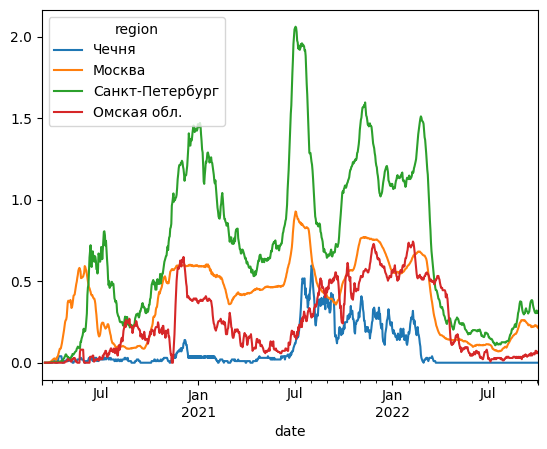

In [15]:
## это -- для напоминания о том, как усреднять по заданному скользящему окну
## и как получать простые графики
ncov_ru_j.loc[['Чечня', 'Москва', 'Санкт-Петербург', 'Омская обл.']].deaths_pd_100k.unstack().T.rolling(7).mean().plot()

Домашнее задание сдаем в виде ноутбука *.ipynb -- можно расшарить ноутбук в Colab'е.  
Обязательно указываем ФИО  
Вопросы категорически приветствуются.